In [1]:
%matplotlib inline

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from random import randint, random
import colorspacious as cs
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from math import ceil, log
from timeit import timeit

In [3]:
URL = 'kvak.jpg'
WIDTH_RESIZE = 1000
LIGHT_THRESHOLD = 10
CHROMA_THRESHOLD = 7
MUD_REMOVAL = 0.8

In [4]:
def show_centroids_as_colors(centroids, title, image_url = URL):
    """ Returns a plot of the image and the centroids as a palette """
    image = load_image(image_url)
    image = resize_image(image, 700)   
    height, width = image.shape[:2]
    image = cv2.rectangle(image, (0, 0), (width, 100), (255, 255, 255), -1)
    palette_size = len(centroids)
    color_width = width / palette_size
    radius = 40
    for i in range(palette_size):
        r, g, b = [round(centroids[i][j]) for j in range(3)]
        center_x = round(color_width * i + color_width / 2)
        center_y = 50
        image = cv2.circle(image, (center_x, center_y), round(radius), (int(r), int(g), int(b)), -1) 
    plt.imshow(image)
    plt.title(title)
    plt.show()

def plot_multiple_palettes(palettes, title):
    palettes = np.array(palettes)
    num_of_palettes = len(palettes)

    color_height = 50
    width = 400
    height = color_height * num_of_palettes

    palette_size = len(palettes[0])
    color_width = width / palette_size
    
    image = np.ones((height, width, 3), dtype=np.uint8) * 255
    for i, palette in enumerate(palettes):
        center_y = 25 + (color_height * i)
        for j , color in enumerate(palette):
            r, g, b = [round(color[i]) for i in range(3)]
            center_x = round(color_width * j + color_width / 2)
            image = cv2.circle(image, (center_x, center_y), round(20), (r, g, b), -1) 

    plt.title(title)
    plt.imshow(np.array(image))
    plt.show()

In [5]:
def plot_clusters(clusters, rows, cols):
    """ 
        clusters: (n, 3), where n is the number of clusters
        rows, cols: int for how many rows and cols to fit subplots in
    """
    fig = plt.figure(figsize = (10, 10))
    for i in range(len(clusters)):
        r, g, b = np.array(clusters[i]).T
        C = [tuple(np.array([r[i], g[i], b[i]]) / 255) for i in range(len(r))]
        ax = fig.add_subplot(rows, cols, i+1, projection='3d')
        ax.set_xlim([0, 255])
        ax.set_ylim([0, 255])
        ax.set_zlim([0, 255])
        ax.set_title('Cluster No. ' + str(i) + ': ' + str(len(clusters[i])) + ' pts')
        ax.scatter(r ,g ,b ,c = C)
    plt.show()

def _get_pixels_subplot(pixels):
    """ Returns a 3D scatter plot of a set of pixels """
    pixels = np.array(pixels)
    r, g, b = [pixels[:, i] for i in range(3)]
    C = [tuple(np.array([r[i], g[i], b[i]]) / 255) for i in range(len(r))]
    subplot = go.Scatter3d(x = r, y = b, z = g, mode='markers',
            marker = dict(
                size = 3,
                color = C,
                opacity = 0.7
            )
        )
    return subplot

def plot_3d_comparison(pixel_arrs, title, subplotTitles):
    """
        Plots 2 3D scatter plots
        pixel_arrs: 3D array containing the sets of pixels
    """
    cols_count = 2
    rows_count = ceil(len(pixel_arrs) / cols_count)
    fig = make_subplots(rows = rows_count, cols = cols_count,
                    specs=[[{'is_3d': True}] * cols_count] * rows_count,
                    print_grid = False,
                    subplot_titles= subplotTitles)
    
    ind = 0
    for ind in range(len(pixel_arrs)):
        subplot = _get_pixels_subplot(pixel_arrs[ind])
        fig.append_trace(subplot, row = ind // cols_count + 1, col = ind % cols_count + 1)

    scene_settings = dict(
            xaxis = dict(range = [0, 255]),
            yaxis = dict(range = [0, 255]),
            zaxis = dict(range = [0, 255]),
            xaxis_title = 'x: Red',
            yaxis_title = 'y: Green',
            zaxis_title = 'z: Blue',
            camera = dict(eye = dict(x = 1, y = -2, z = 1))
            )
    
    fig.update_yaxes(dict(range = [0, 255], title = 'Green'))
    fig.update_layout(
        scene = scene_settings,
        scene2 = scene_settings,
        width = 1400,
        height = 700,
        showlegend = False,
        scene_aspectmode='cube')
    fig.show()
        

# Creating Pointilism Paintings from Images # 

## Introduction ##

#### Pointilism ####
Pointilism is a painting technique that is characterized by using small dots with no blending inbetween. Unlike other painting techniques, Pointilism does not involve mixing colors on the artist's palette, nor blending them on the canvas. That work is left to the human eye, which blends the tiny dots of distinct color optically as it moves away from the canvas. And this is where the beauty of it lies - no matter how "muddy" an area of the painting might look from afar, when you get really close, you will see it is actually made up of tiny dots of vibrant colors. 

<blockquote>"It enjoys a duality in being both discrete up close and continuous from distance." [4]</blockquote>

<div style="display: flex; color: gray"> 
    <figure>
        <img width=300 src="https://upload.wikimedia.org/wikipedia/commons/5/5d/Seurat-La_Parade_detail.jpg" /> 
        <figcaption> Detail from Seurat's Parade de cirque, 1889</figcaption>
    </figure>
    <figure>
        <img width=750 src="https://principlegallery.files.wordpress.com/2015/05/3716.jpg">
        <figcaption> Seurat's Parade de cirque, 1889</figcaption>
    </figure></div>

#### And how is that related to computers? ####
This project is my attempt to create an algorithm to mimick these techniques and apply them to "paint from reference" (the input image). Theis kind of rendering algorithm falls under the area of Computer Graphics called "Non-photorealistic rendering" (NPR), in particular, a branch called "Image-based artistic rendering" (IBAR). NPR/IBAR, in contrast to realistic rendering, is focused on creating expressive and stylized images, conveying a feeling rather than accurately describing every piece of information. Essentialy, kind of like an artistic filter. It is used in movies, video games, cartoons and so on. [1]


##### *Small Disclaimer #####
Okay, I lied a little... Pointilism is a technique that is <strong>only</strong> concerned with the brushstroke - the dot. [2] The theory of mixing colors optically and its application are a separate style called Divisionism (or Chromoluminarism), which is often applied together with pointilism. <br>
Some quick Art Histroy Math: <br>
Pointilism + Divisionism = pretty much makes up Neo-Impresionism. [5] <br> 
But enough of that. 

### For the sake of this project, the word "Pointilism" will mean: ###

1\. <strong>Made up of tiny dabs of colors (strokes)</strong>

2\. <strong>No blending between the strokes or "in the palette"</strong>

3\. <strong>Precise application, especially with regards to detail</strong>

4\. <strong>Viewing at a distance effect of optically blending colors</strong>

5\. And, of course, <strong>aesthetics</strong>. The output image must be expressive and artistic (I want those Van Gogh swirlies even though, technically, he's a post-impressionist, sue me)





### Building blocks ###

Essentially, I want to input an image file and get a pointilism paintng. Here are the basic building blocks:

#### An Image: ####

An <strong>image</strong> is represented by a three dimensional array with shape: $ ( \text{height}, \text{width}, \text{color channels} ) $  <br>
<code> image[row][col] </code> will give us the color of the pixel with those coordinates. ((0, 0) is the top left corner of the image)

In [6]:
def load_image(src):
    # Takes a path to an image and returns an image as 3 dimensional array
    img = cv2.cvtColor(cv2.imread(src), cv2.COLOR_BGR2RGB)
    return img

In [7]:
def resize_image(img, width_resize = WIDTH_RESIZE):
    height, width = img.shape[:2]
    height_resize = round(height * ( width_resize / width))
    return cv2.resize(img, (width_resize, height_resize))

In [8]:
img_fullsize = load_image(URL)
img = resize_image(img_fullsize)
print (img_fullsize.shape, img.shape)

(3456, 2304, 3) (1500, 1000, 3)


#### A color: ####
For the colors, I've stuck with the <strong>RGB color space </strong>. <br>
A <strong>color</strong> is represented by an array of three values: $ (\text{red}, \text{blue}, \text{green}) $ <br>
They can be values between 0 to 255.

In [9]:
print ("the RGB color of pixel at (0, 45): ", img_fullsize[0][45])

the RGB color of pixel at (0, 45):  [12 37 31]


#### A brushstroke: ####

Brushtrokes are used to create the final "painting". From up-close what I will call a brushstroke is an <strong>elipse with a flat color</strong> (no gradients or transperancy), satisfying requirements 1 and 2 - small dabs of color and no blending. 
It also has the following properties:

1\. Position <br>
2\. Size (horizontal and vertical)<br>
3\. Color <br>
4\. Direction <br>
The following paragraphs explain how the values for these properties are derived.


## 1. Palette extraction with K-means++ ##

#### Resizing the image ####

Resizing the image, sacrificng some information, because:

1\. I only need a restricted palette anyway <br>
2\. Less pixels means less calculations means less time (Optimization) <br>

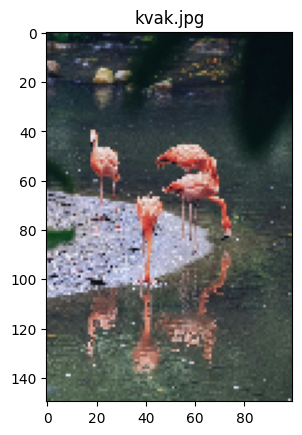

In [10]:
img_p = resize_image(img_fullsize, 100)
plt.imshow(img_p)
plt.title(URL)
plt.show()

#### Euclidean distance ####

In [11]:
def euclidean(point, centroids):
    """
    Euclidean distance between point & centroids.
    Point has dimensions (m,), centroids has dimensions (n,m), and output will be of size (n,).
    """
    return np.sqrt(np.sum((point - centroids)**2, axis = 1))

### K-means++ ###

After dabbling with K-means and specifically, choice of initial centroids (Link here), I am using the following steps to choose centroids:
#### Steps for choosing centroids: #####

For k-means, we need $k$ - integer for how many clusters we want (how many colors in the palette), $X$ - data points (the pixel colors)

1\. Choose one center $ c_1 $ uniformly at random among the data points. <br>
2\. For each data point $x$, calculate $ D(x) $ - the Euclidean distance between $x$ and the nearest center that has already been chosen <br>
3\. Choose one new data point at random as a new center $c_2$, using a weighted probability distribution where a point x is chosen with probability proportional to $ D(x)^2 $:
$$ p = \frac{D(x)^2}{\sum_{x \in X} D(x)^2} $$ <br>
4\. Repeat steps 2 and 3 until k centers have been chosen. <br>
5\. Proceed with standard k-means clustering


In [30]:
class KMeans:
    def __init__(self, n_clusters = 8, max_iter = 200):
        self.n_clusters = n_clusters
        self.max_iter = max_iter

    def define_centroids(self, points):
        """ picks n_clusters amount of centroids from points """
        chosen_centroid_inds = [randint(0, len(points)- 1)]
        self.centroids = [points[chosen_centroid_inds[0]]]
    
        while (len(self.centroids) < self.n_clusters):
            dists = []
            for i in range(len(points)):
                if i not in chosen_centroid_inds:
                    min_dist = np.min(euclidean(points[i], self.centroids)) ** 2
                    dists.append(min_dist)
                else:
                    dists.append(0)
            dists /= np.sum(dists)
            new_centroid_idx, = np.random.choice(range(len(points)), size = 1, p = dists)
            self.centroids.append(points[new_centroid_idx])
            chosen_centroid_inds.append(new_centroid_idx)

    def clean_muddy_colors(self, points):
        """ Removes low chroma colors with probablity of MUD_REMOVAL,
            returns a 2D array of pixes left and pixels removed 
        """
        points = np.array(points)
        C_is_low = np.array(cs.cspace_convert(points, "sRGB255", "CIELCh")[::,1]) < CHROMA_THRESHOLD
        
        muddy_color_idxs = []
        clean_points = []

        for i, point in enumerate(points):
            if random() < MUD_REMOVAL:
                if C_is_low[i]:
                    muddy_color_idxs.append(i)
            else:
                clean_points.append(point)
        return [clean_points, muddy_color_idxs]    

    def fit(self, points, clean_muddy = True): 
        """ 
            Finds n_cluster amount of clusters and assigns their centroids to self.centroids
            Returns a 2D array of points used and points cleaned (for plotting purposes)
        """
        muddy_color_idxs = []
        self.define_centroids(points)
        if clean_muddy:
            points, muddy_color_idxs = self.clean_muddy_colors(points)
        iteration = 0
        prev_centroids = None

        while np.not_equal(self.centroids, prev_centroids).any() and \
        iteration < self.max_iter:
            sorted_points = [[] for _ in range(self.n_clusters)]
            for x in points:
                dists = euclidean(x, self.centroids)
                centroid_idx = np.argmin(dists)
                sorted_points[centroid_idx].append(x)
            prev_centroids = self.centroids
            self.centroids = [np.mean(cluster, axis = 0) for cluster in sorted_points]
            for i, centroid in enumerate(self.centroids):
                if np.isnan(centroid).any():
                    self.centroids[i] = prev_centroids[i]
            iteration += 1
        return [points, muddy_color_idxs]

    def get_points_by_cluster(self, points):
        """ Groups a set of points by self.centroids """
        centroids = [[] for c in self.centroids]
        for x in points:
            dists = euclidean(x, self.centroids)
            centroid_idx = np.argmin(dists)
            centroids[centroid_idx].append(x)
        return centroids

    def get_dists_for_point(self, point):
        """ Returns the distances from a point to all self.centroids """
        return euclidean(point, self.centroids)

    def enrich_color(self, color, intensity):
        """ Intensifies color chroma and lightness """
        L, A, B = cs.cspace_convert(color, "sRGB255", "CIELab")
        A_sign = (-1) ** int(A < 0)
        B_sign = (-1) ** int(B < 0)
        brighter_lab = [L + intensity / 2, 
                        A + intensity * A_sign, 
                        B + intensity * B_sign]
        return cs.cspace_convert(brighter_lab, "CIELab", "sRGB255")

    def enrich_palette(self, intensity = 3):
        """ 
            Increases chroma and lightness of self.centroids and 
            appends the result to self.centroids
        """
        highlights = []
        shadows = []
        for color in self.centroids:
            highlights.append(self.enrich_color(color, intensity))
            
        enriched_palette = [palette.centroids, highlights]
        plot_multiple_palettes(enriched_palette, 'Final Enriched Palette')
        palette.centroids = self.centroids + highlights


### A smaller palette for demonstration purposes ###

In [13]:
pixels = img_p.reshape(-1, 3)
palette = KMeans(6, 30)

points, muddy_color_idxs = palette.fit(pixels)

points_by_cluster = palette.get_points_by_cluster(pixels)

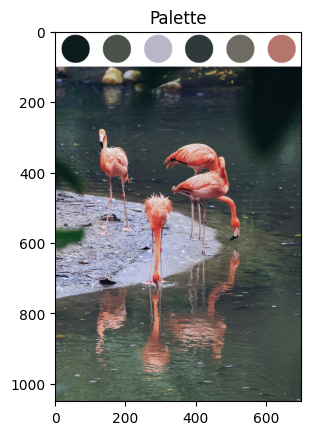

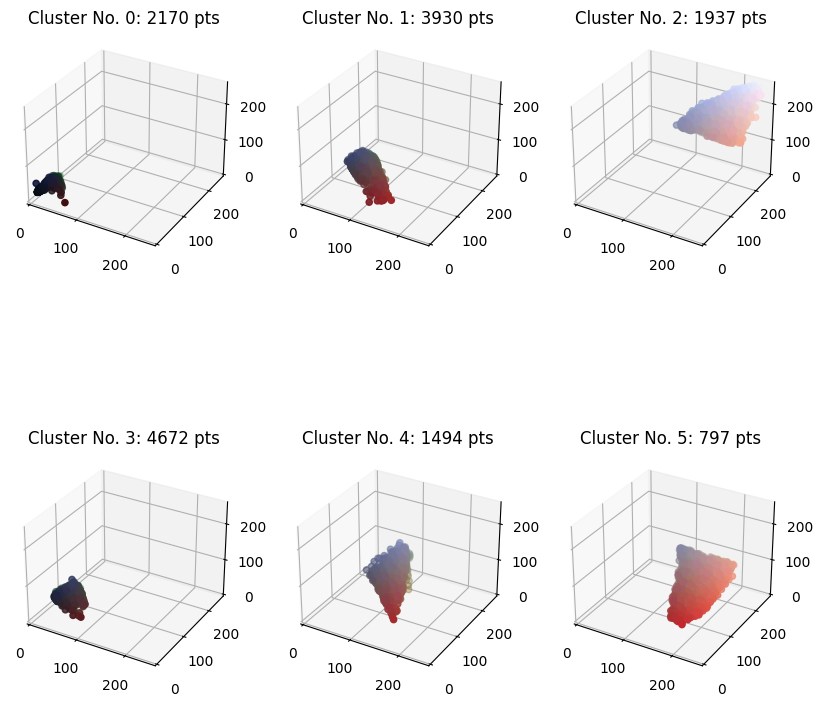

In [14]:
show_centroids_as_colors(palette.centroids, "Palette", URL)
plot_clusters(points_by_cluster, 2, 3)

#### Cleaning muddy colors and my search for local color ####

Colors which artists often call "muddy" are colors, which tend to be grayish. In photo images these colors appear very often due to shadows, reflections, overall scene lightning etc. Two different colors will produce a shadow color with an insignificant to the human eye hue difference. That makes for a lot of mud. <br>
Also, an object can <i>appear</i> one color in the context of the image but be a completely different color when isolated (colorpicked). This causes a discrepancy between the perception of the human eye and the actual data. 

<figure>
    <img src='https://www.explainxkcd.com/wiki/images/a/ae/dress.png'/>
    <figcaption>Example of color context effects with the notorious Blue/White dress</figcaption>
</figure>

Expecting Kmeans to find local color is unrealistic, however, I tried to at least "clean up the mud" in an attempt to give weight to the brighter colors we silly humans seem to enjoy so much: <br>
I picked mud by choosing every pixel that has <strong>low chroma</strong> with a probability of 80% (or whatever MUD_REMOVAL is set to)

<strong> Result: </strong><br>
Did that give me better colors? No. Did I accidentally speed up my process a bit with no significant change to the results? Yes. 


In [15]:
%%timeit
KMeans(5).fit(pixels)

2.04 s ± 274 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%%timeit
KMeans(5).fit(pixels, False)

6.51 s ± 1.48 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


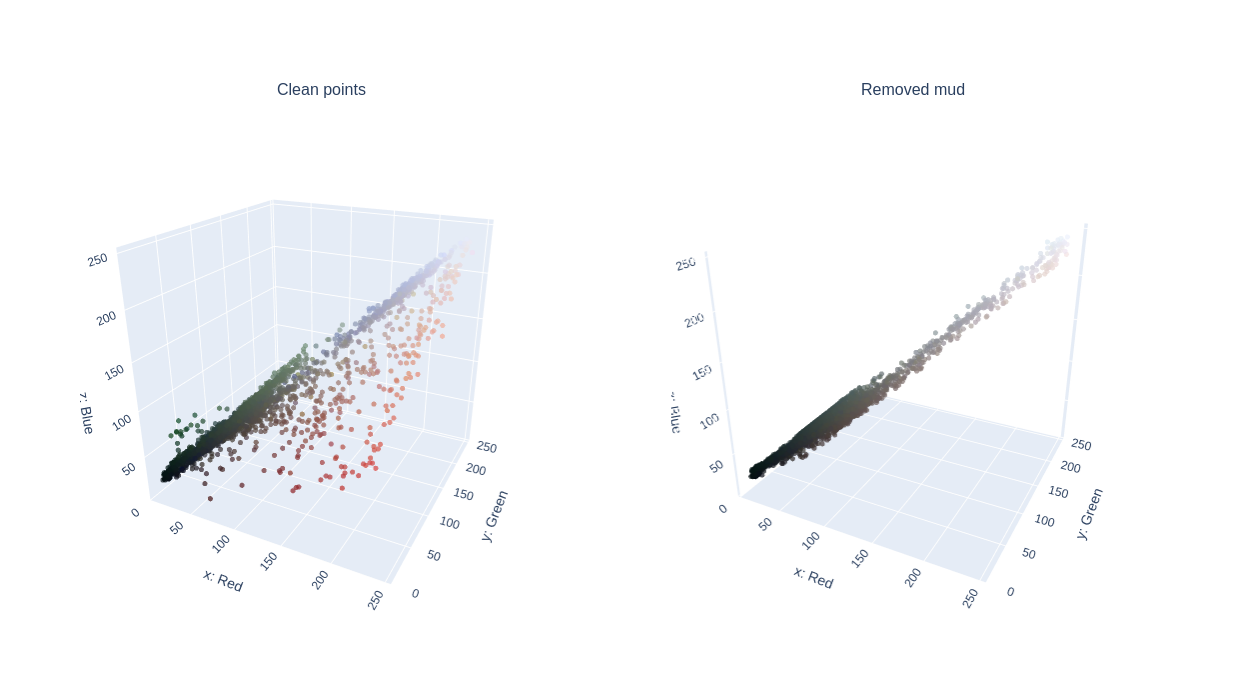

In [17]:
mud = [pixels[i] for i in muddy_color_idxs]
plot_3d_comparison([points, mud], "Clean points vs. Removed mud", ["Clean points", "Removed mud"])

#### Enriching the palette ####

Finally, I decided to go with what was suggested in the articles [4][8] and alter the final palette. I increase every color's chroma and brightness and then add the new palette to the old one.

$$ [l, a, b] \xrightarrow[]{\text{enhance}} [l + \frac{I}{2},\; a + I * s_a, \; b + I * s_b] \newline
\text{Where } I \;\text{is the intensity of the change and } s_a, s_b \;\text{are the signs of the a and b values}
$$

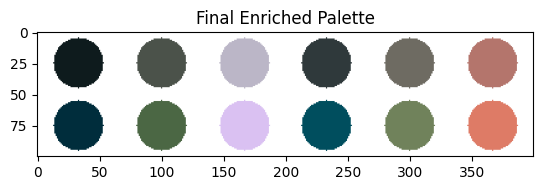

In [18]:
palette.enrich_palette(13)

## 2. Edge detection for brushstroke size and direction ##


### Preparing the image ###

Converting to grayscale and blurring using Gaussian Blur to reduce noise but preserve edges.

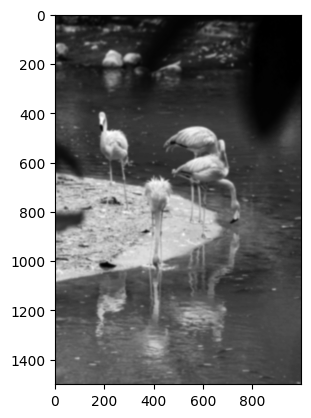

In [19]:
def to_grayscale(img):
    r, g, b = [img[:, :, i]/255 for i in range(3)]
    # Yes, I'm stealing from Linear Algebra homework
    grayscale_img = (0.299 * r + 
                        0.587 * g + 
                        0.114 * b)
    return grayscale_img

grayscale_img = to_grayscale(img)
# Very cool function, but for another time
blurred_img = cv2.GaussianBlur(grayscale_img, (17, 17), 3)

plt.imshow(blurred_img, cmap="gray")
plt.show()

### Sobel Filter and Convolution ###

The Sobel filter, when applied to the grayscale image, will give us a map of where changes in value are the most drastic (Bigger number means bigger, more rapid change in that area). Most often those changes appear in a photo at places where objects ends and background/other objects begin - edges. Of course, it is not perfect, however, for the purposes of this project it is enough. 

It uses two 3x3 kernesl $S_x, S_y$ - for the horizontal and vertical change, respectively (Seen in the code below)

Applying the Sobel Filter looks like this:
$$ G_x = S_x * A \newline
G_y = S_y * A $$

Where $ A $ is the original image, $G_x, G_y$ are the "edge images" in the corresponding direction and $ * $ stands for convolution

In [20]:
Sx = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]])

Sy = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]])

In [21]:
def simple_convolve(kernel, matrix):
    m_rows, m_cols = matrix.shape
    res = np.zeros((m_rows, m_cols), dtype=np.float32)
    _kernel = kernel.ravel()

    for i in range(m_rows):
        for j in range(m_cols):
            k_ind = 0
            for _i in range(i - 1, i + 2):
                for _j in range(j - 1, j + 2):
                    if _i < 0 or _i >= len(matrix) or _j < 0 or _j >= len(matrix[0]):
                        elem = 0.5
                    else:
                        elem = matrix[_i][_j]
                    res[i][j] += elem * _kernel[k_ind]
                    k_ind += 1
    return res

### Finding the edges ###

We combine what is known about the change in horizontal direction and vertical driection to get the gradient map, using Euclidean distance (yet again):

$$ G = \sqrt{G_x^2 + G_y^2} $$

#### Brushtroke size ####
Artists use contrast and detail to guide the human eye. This algorithm will use "broad" brushstrokes where there's not much detail (edges) and smaller ones where there is. 

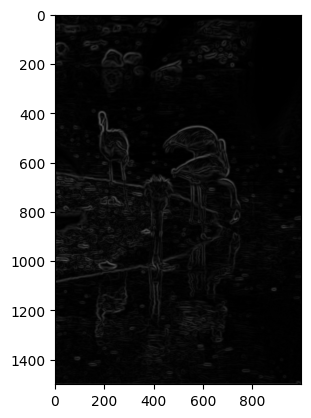

In [22]:
Gx = simple_convolve(Sx, blurred_img)
Gy = simple_convolve(Sy, blurred_img)

edges = np.sqrt(Gx ** 2 + Gy ** 2)

plt.imshow(edges, cmap="gray")
plt.show()

#### Brushstroke direction ####

First of all, we know how much an edge changes horizontally $G_x$ and vertically $G_y$. That means that we can calculate the direction of the change $\theta$:
    $$ \theta = \arctan(G_y, G_x) $$

$$\theta + 90 $$ gives us the direction of the edge - the direction in which we want to "drag our brush".

\* Since the initial calculations are more precise than what I need (gradual, artistic broad strokes), $G_x$ , $G_y$ are smoothed. This gives the brushstrokes a more readable flow and also creates those lovely Van Gogh swirles in the areas with small values.

In [23]:
Gx_smooth = cv2.GaussianBlur(Gx, (71, 71), 0)
Gy_smooth = cv2.GaussianBlur(Gy, (71, 71), 0)

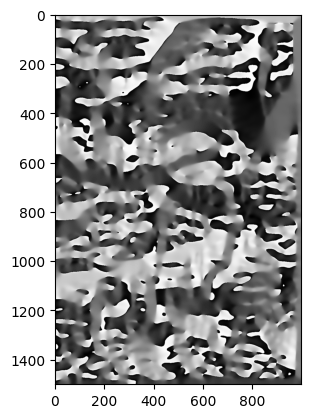

In [24]:
thetas = np.arctan2(Gy_smooth, Gx_smooth)
plt.imshow(thetas, cmap="gray")
plt.show()

## 3. Painting with brushstrokes ##

Here is where the brushstroke characteristics from earlier finally get their values:
1\. Position - one of 10,000 positions at random<br>
2\. Size (horizontal and vertical) - calculated with respect to $G$<br>
3\. Color - chosen with weighted probabilities based on how "close" the palette colors are to the pixel at that position<br>
4\. Direction - $\theta$ + 90; since $\theta$ gives up the direction of change, adding 90 gives the direction of the edge

In [25]:
def pick_stroke_positions(number, img):
    """ Picks a number amount of unique (x, y) positions within img """
    height, width, _ = img.shape
    pos = set()
    while len(pos) < number:
        pos.add((randint(0, width - 1), randint(0, height- 1)))
    return np.array(list(pos))

def choose_weighted_color(pixel, palette):
    """ Picks a color from palette using weighted probability based off distances """
    probabilities = palette.get_dists_for_point(pixel)
    max_v = np.max(probabilities)
    probabilities = max_v - probabilities
    probabilities = probabilities ** 13
    probabilities /= np.sum(probabilities)
    color_id, = np.random.choice(range(len(probabilities)), size = 1, p = probabilities)
    return palette.centroids[color_id]

def paint(name, palette):
    """ 
        Creates a pointilism painting "from reference" 
        using palette for colors
    """
    _img = cv2.GaussianBlur(img, (15, 15), 0)
    positions = pick_stroke_positions(100_000, _img)
    colors = []
    pixels = []
    for (x, y) in positions:
        pixel = img[y][x]
        pixels.append(pixel)
        color = choose_weighted_color(pixel, palette)
        colors.append(color)
        r, g, b = color
        stroke_width = round(min(4 + 0.05 / edges[y, x], 10))
        stroke_height = round(max(stroke_width / 5, 2))
        _img = cv2.ellipse(_img, (x, y), (stroke_width, stroke_height), -(np.degrees(thetas[y][x]) + 90), 0, 360, (int(r), int(g), int(b)), -1, cv2.LINE_AA) 
    plt.imshow(_img)
    plt.show()
    cv2.imwrite(name, cv2.cvtColor(_img, cv2.COLOR_RGB2BGR))
    return [pixels, colors]


In [26]:
pixels = img_p.reshape(-1, 3)
palette = KMeans(15)

points, mud = palette.fit(pixels)

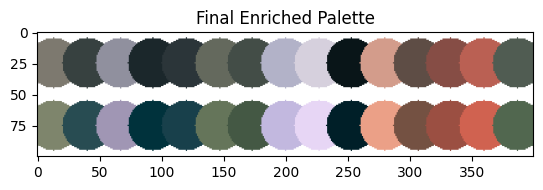

In [27]:
palette.enrich_palette(7)

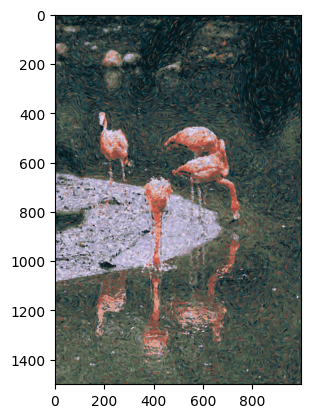

In [29]:
pixels, colors = paint('kvak_pointilism.jpeg', palette)

## 4. Conclusion and room for growth ##

Neo-Impressionists and Divisionists in particular, claimed they were using science (the optical color mixing) to make their art more luminous. They believed that putting vibrant but opposite colors next to each other, that optically blur to gray, creates a deeper experience for the human eye. Even though that is actually a misconception because "additive luminosity is only applicable in the case of colored light, not juxtaposed pigments" [3], this project made me think that maybe there is science to some parts of the movement, after all.

This project holds many more unexplored possibilities. In the future, I would like to see how I can push the hue of some of the colors in the enriched palette to achieve better juxtaposition. Maybe dive deeper into color theory and use more than just probability to choose colors for juxtaposition.  It would be interesting to play with opacity and shape of the strokes. There are many things that should be done to achieve code cleanliness. Variables that can be separated as tweakable constants, which would increase usability.

<div style="display:flex; color: gray">
    <figure>
        <img width=500 src='https://images.pexels.com/photos/16614230/pexels-photo-16614230/free-photo-of-flamingos-by-the-water.jpeg' />
        <figcaption>Original image</figcaption>
    </figure>
    <figure>
        <img width=500 src='https://i.ibb.co/McQvcZH/kvak-pointilism.jpg' />  
        <figcaption>Pointilist painting of original image</figcaption>
    </figure>
    <figure>
        <img height=300 src='https://i.ibb.co/qyvtbP8/closeup.png'/>
        <figcaption>Detail of pointilist painting</figcaption>
    </figure>
</div>


### References ###
1\. [Non-photorealistic rendering
 Wikipedia](https://en.wikipedia.org/wiki/Non-photorealistic_rendering#:~:text=Non%2Dphotorealistic%20rendering%20(NPR),graphics%2C%20which%20focuses%20on%20photorealism.)

2\. [Pointilism](http://www.visual-arts-cork.com/history-of-art/pointillism.htm)

3\. [Divisionism](https://en.wikipedia.org/wiki/Divisionism)

4\. [Create Pointillism Art from Digital Images ](chrome-extension://oemmndcbldboiebfnladdacbdfmadadm/file:///home/avgustina/python/Hong_Liu.pdf) by Yanshu Hong and Tiffany Liu

5\. [Neo-Impressionism](https://en.wikipedia.org/wiki/Neo-Impressionism)

6\. [Wikipedia k-means++](https://en.wikipedia.org/wiki/K-means%2B%2B)

7\. [k-means++: The Advantages of Careful Seeding](chrome-extension://oemmndcbldboiebfnladdacbdfmadadm/http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf)

8\. [Creating Pointillist Paintings with Python and OpenCV
](https://hackernoon.com/https-medium-com-matteoronchetti-pointillism-with-python-and-opencv-f4274e6bbb7b) - What I primarily stuck to when it came to approach

9\. [Blue and Black or White and Gold Dress Photo](https://www.explainxkcd.com/wiki/index.php/1492:_Dress_Color)

10\. [colorspacious CIELab documentation](https://colorspacious.readthedocs.io/en/latest/reference.html#conversion-functions)

11\. [Sobel Operator](https://en.wikipedia.org/wiki/Sobel_operator)

12\. [Flamingo Photo by Mehmet Turgut  Kirkgoz](https://www.pexels.com/photo/flamingos-by-the-water-16614230/)

13\. [Research ArticleA Natural Image Pointillism with Controlled Ellipse Dots](https://www.researchgate.net/publication/286001164_A_Natural_Image_Pointillism_with_Controlled_Ellipse_Dots)